##### Modelo SEIR (Susceptibles, Expuestos, Infeccioso, Recuperados, Fallecidos) con Cuarentena

In [1]:
import numpy as np
import scipy
import scipy.integrate
import lmfit

from utilidades import *

def seir_model(SEIR, beta, sigma, gamma, mu, phi=0.):
    S, E, I, R, F = SEIR
    
    # Poblacion
    N = S + E + I + R
    
    # - Los susceptibles que pasan a expuestos a razon `beta` * (1 - phi)
    dS = - beta * (1 - phi) * S * I / N
    # + Los susceptibles que pasan a expuestos a razon `beta`* (1 - phi)
    # - Los expuestos que pasan a infeccioso a razon `sigma`
    dE = beta * (1 - phi) * S * I / N - sigma * E
    # + Los expuestos que pasan a infeccioso a razon `sigma`
    # - Los infeccioso que pasan a recuperados a razon `gamma`
    # - Los infeccioso que pasan a fallecidos a razon `mu`
    dI = sigma * E - gamma * I - mu * I
    # + Los infeccioso que pasan a recuperados a razon `gamma`
    dR = gamma * I
    # + Los infeccioso que pasan a fallecidos a razon `mu`
    dF = mu * I
    
    return [
        dS, dE, dI, dR, dF
    ]


Clases:
    * Susceptible
    * Expuesto
    * Infeccioso
    * Recuperado
    * Fallecido
    
Parametros:  
    * `beta` es la razon de transmision  
    * `sigma` es la razon de transicion de Expuesto a Infeccioso  
    * `gamma` es la razon de transicion de Infeccioso a Recuperado (o aislado)  
    * `mu` es la razon de transicion de Infeccioso a Fallecido
Nuevos Parametros:  
    * `phi` es el % de aislacion de la poblacion en cuarentena

In [2]:
R0 = 2.5

periodo_incubacion = 5.2
periodo_infeccioso = 7.
razon_mortalidad = 2. / 100.0 # Pareciera estar entre 0.5% y 1.5%

infectados_t0 = 16.
susceptibles_t0 = population_t0 = 11e6
recovered_t0 = 0.

data = load_data()

In [3]:
def process_solution(solution):
    infected = solution['y'][1] + solution['y'][2]
    return {
        't': solution['t'],
        # base
        'susceptible': solution['y'][0],
        'exposed': solution['y'][1],
        'infectious': solution['y'][2],
        'recovered': solution['y'][3],
        'death': solution['y'][4],
        # +
        'infected': infected,
        'new_cases': np.diff(
            infected, prepend=[infected[0]]
        ),
    }

def run_model(params, days):
    if type(params) == lmfit.Parameters:
        params = [param.value for param in params.values()]
        
    SEIR_t0 = (
        susceptibles_t0,
        infectados_t0 * R0, # expuestos
        infectados_t0,
        recovered_t0, 0 # recuperados, fallecidos
    )
    
    solution = run(
        seir_model,
        SEIR_t0,
        beta = R0 / periodo_infeccioso,
        sigma = 1. / periodo_incubacion,
        gamma = 1. / periodo_infeccioso,
        mu = razon_mortalidad / (periodo_infeccioso * 1.5),
        phi = params,
        days = days,
        step = 1
    )
    return process_solution(solution)

# https://benjaminmoll.com/wp-content/uploads/2020/05/SIR_notes.pdf
def phase_transition(solution, ax = None):
    ax = draw_curve_inflection(
        100. * solution['susceptible'] / population_t0, 
        100. * solution['infected'] / population_t0,
        direction = 'v',
        ax = ax
    )
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.set_title('Diagrama de fase')
    ax.set(xlabel='Susceptibles (%)', ylabel='Infectados (%)')
    
    return ax

profile = np.array(int(periodo_infeccioso) * [1] + int(periodo_incubacion) * [0])
profile = profile / sum(profile)

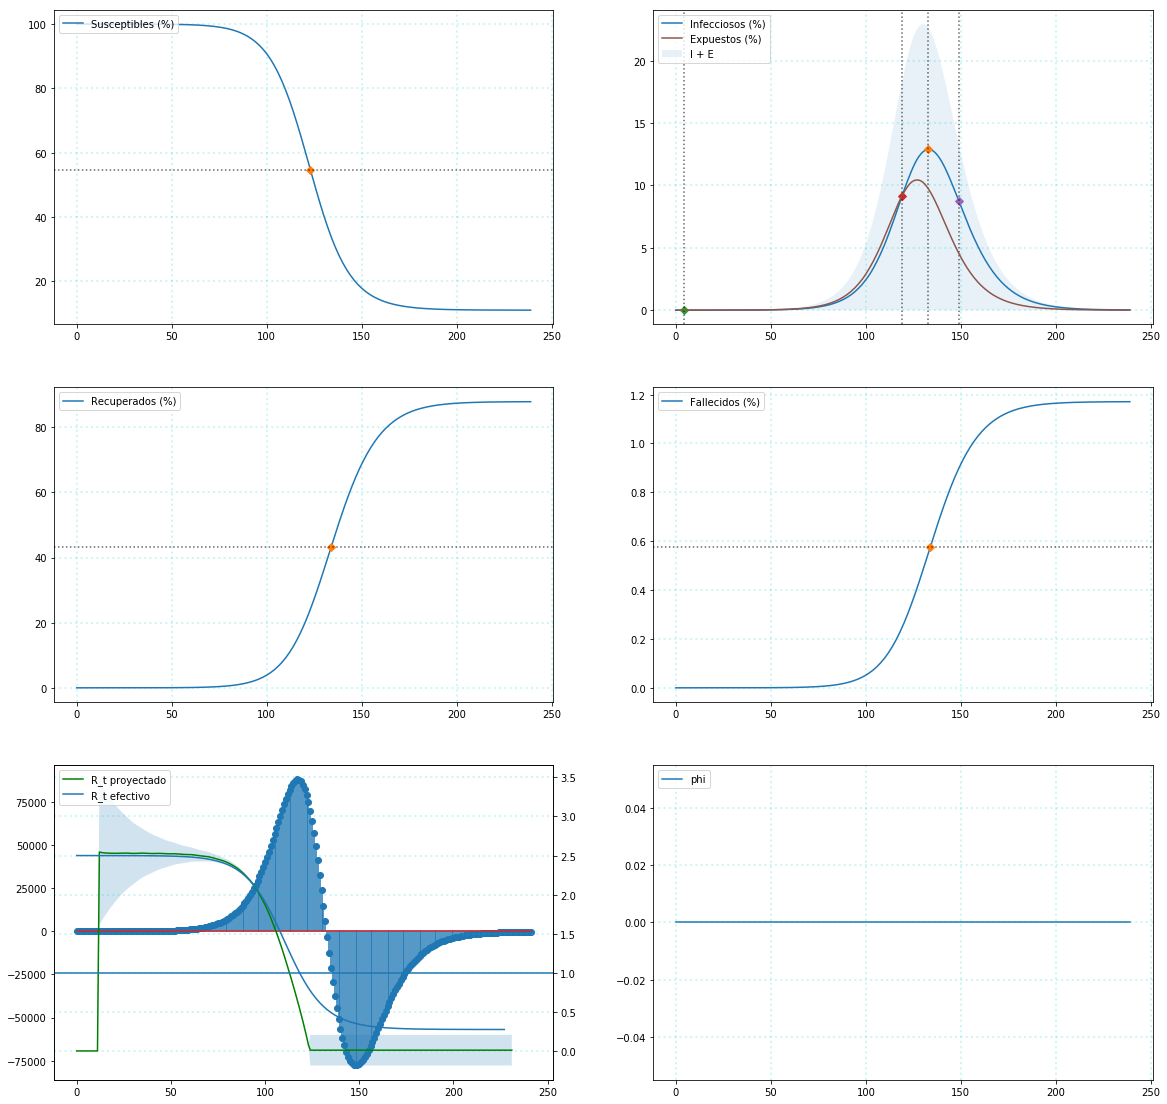

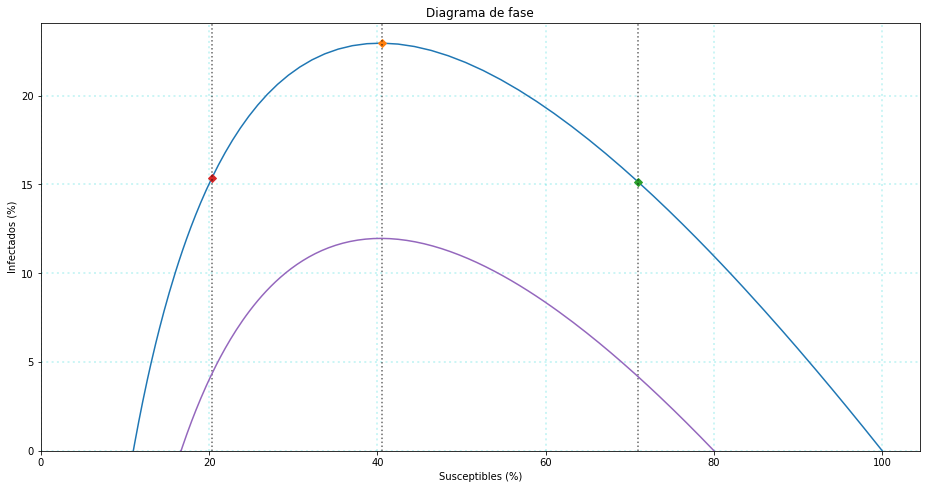

In [4]:
susceptibles_t0 = population_t0 
recovered_t0 = 0.

lockdowns = [0.]
days = [240]

solution = run_model(lockdowns, days)

_ = describe_simulation(solution, {
    'phi': lockdowns,
    'R0': R0
}, days, infectivity_profile=profile)

ax = phase_transition(solution)
first_solution = solution

susceptibles_t0 = population_t0 * .8
recovered_t0 = population_t0 * .2

solution = run_model(lockdowns, [800])

_ = ax.plot(
    100. * solution['susceptible'] / population_t0, 
    100. * solution['infected'] / population_t0,
)

Si la cantidad de Susceptibles > el umbral de inmunidad, entonces puede haber una epidemia.  
En el punto maximo de infectados concurrentes la epidemia comienza a retroceder (hay una transicion de fase).  
La velocidad de la epidemia es mucho menor en la parte inferior del diagrama de fase.  
La idea es superar el umbral con la menor cantidad de infectados concurrentes.

###### Cuarentena estricta y corta

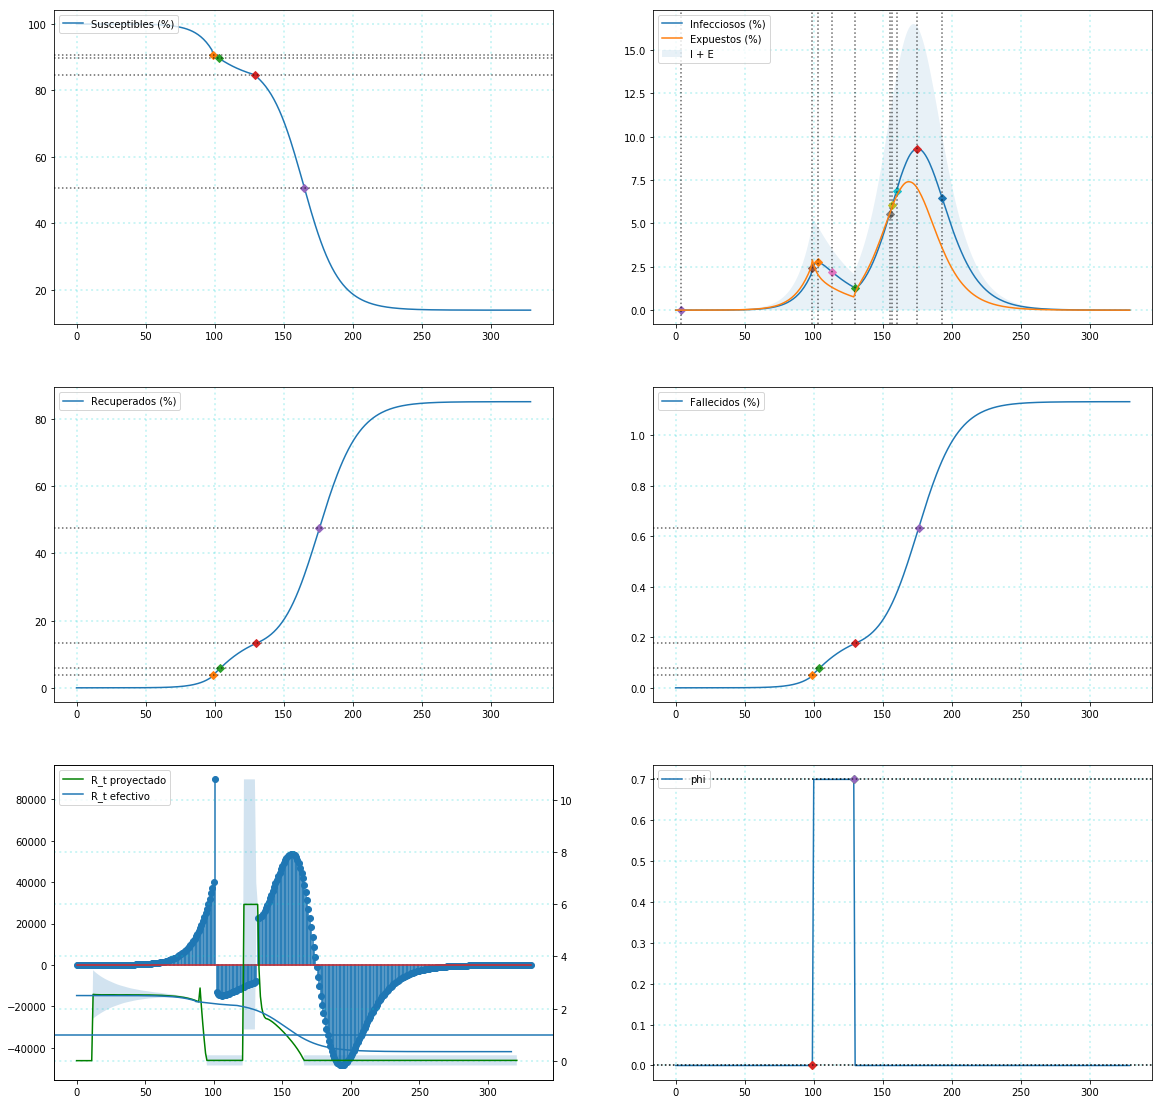

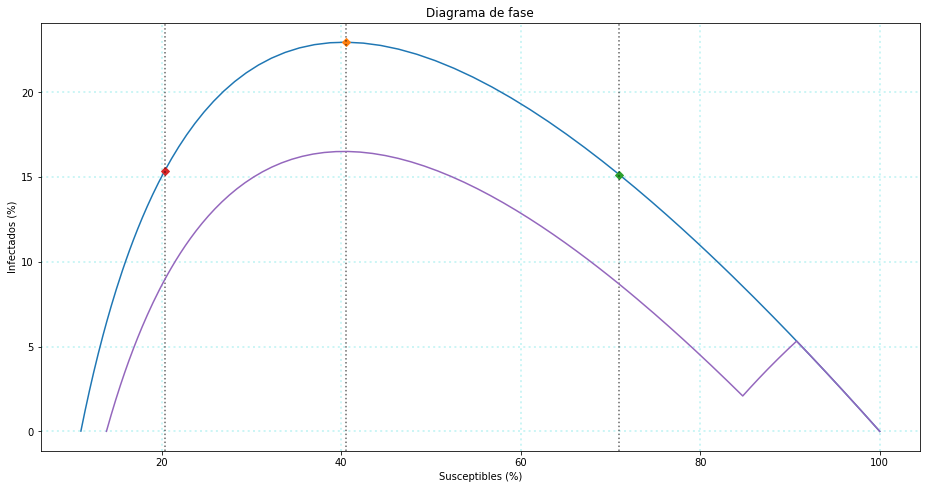

In [5]:
susceptibles_t0 = population_t0 
recovered_t0 = 0.

lockdowns = [0., .7, 0.]
days = [100, 30, 200]

solution = run_model(lockdowns, days)

_ = describe_simulation(solution, {
    'phi': lockdowns,
    'R0': R0
}, days, infectivity_profile=profile)

ax = phase_transition(first_solution)
ax.plot(
    100. * solution['susceptible'] / population_t0, 
    100. * solution['infected'] / population_t0,
)
_ = ax.autoscale()

Reduce muy poco la mortalidad.  
Hubo un ~ 30% de reduccion en el pico, pero la segunda ola del virus fue fuertisima.

###### Cuarentena floja y larga

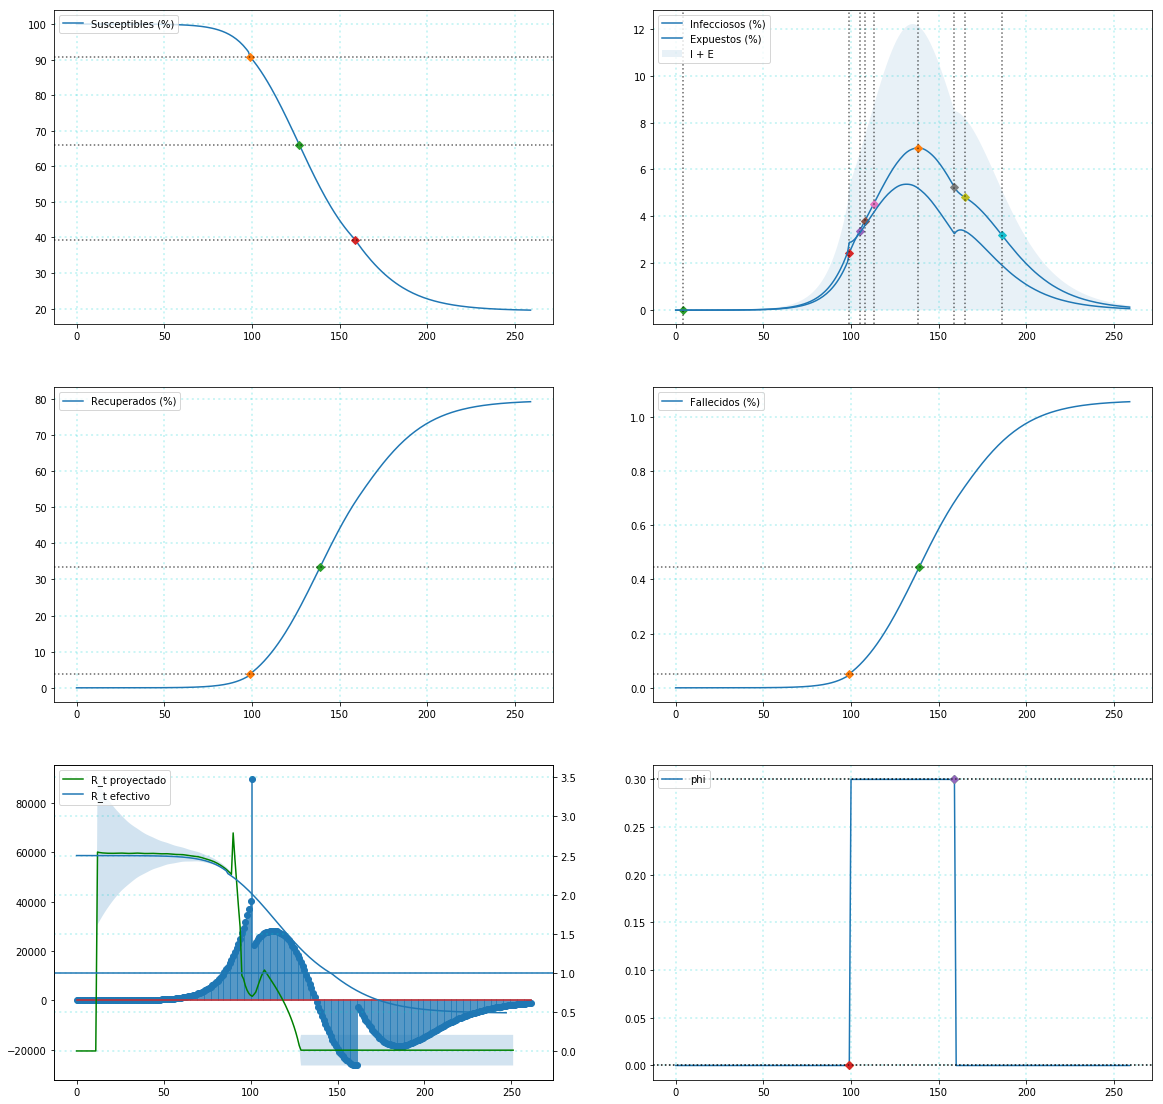

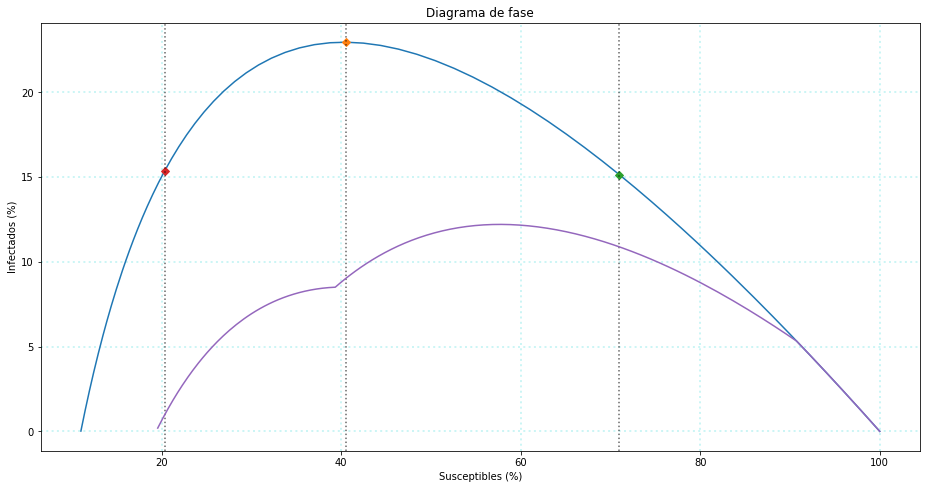

In [6]:
lockdowns = [0., .3, 0.]
days = [100, 60, 100]

solution = run_model(lockdowns, days)

_ = describe_simulation(solution, {
    'phi': lockdowns,
    'R0': R0
}, days, infectivity_profile=profile)

ax = phase_transition(first_solution)
ax.plot(
    100. * solution['susceptible'] / population_t0, 
    100. * solution['infected'] / population_t0,
)
_ = ax.autoscale()

Reduce la mortalidad mas que el confinamiento estricto.  
Reduce el pico en ~ 45%

###### Cuarentena intermitente

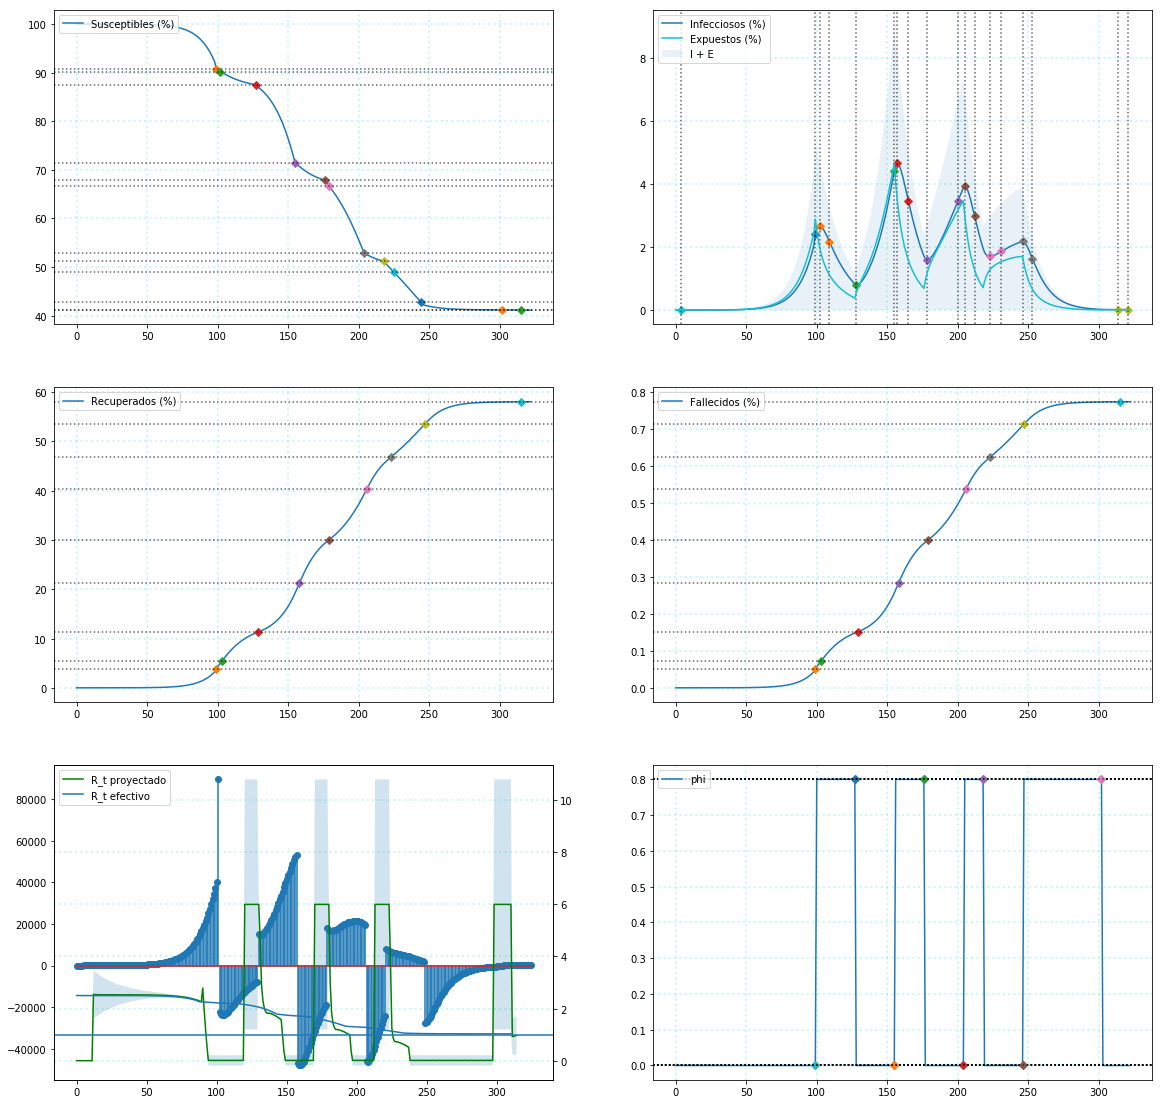

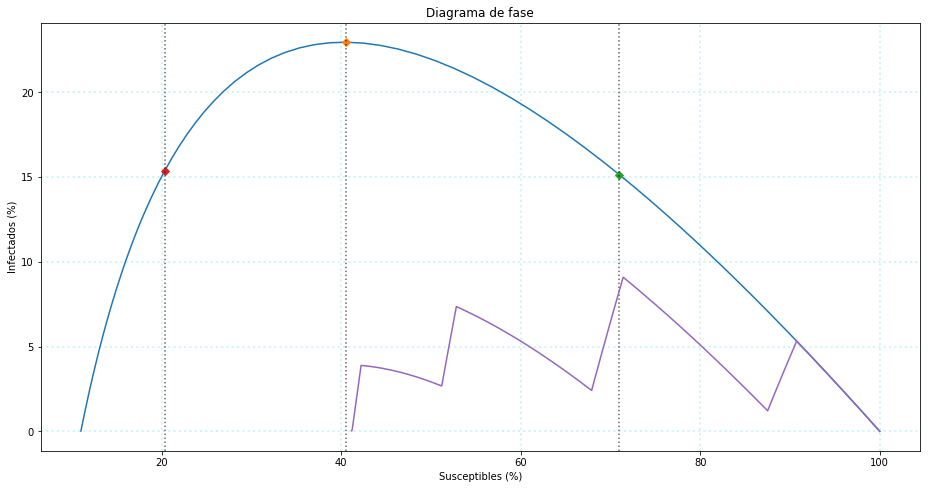

In [7]:
lockdowns = [0.] + [.8, 0.] * 4
days = [100] + [28, 28, 21, 28, 14, 28, 56, 20]

solution = run_model(lockdowns, days)

_ = describe_simulation(solution, {
    'phi': lockdowns,
    'R0': R0
}, days, infectivity_profile=profile)

ax = phase_transition(first_solution)
ax.plot(
    100. * solution['susceptible'] / population_t0, 
    100. * solution['infected'] / population_t0,
)
_ = ax.autoscale()

Reduce la mortalidad mas que el confinamiento flojo.  
Reduce el pico en ~ 66%

Notas:
* Nada de esto toma en cuenta medidas como las pruebas, seguimiento de contactos, higiene, etc.
* Si el objetivo del confinamiento es: 
    * intentar alcanzar inmunidad de grupo de un cierto % de la poblacion, el costo en vidas es muy alto.
    * ganar tiempo para poder equipar al sistema de salud, entonces la responsabilidad es compartida, fracasara sin medidas correctas de prueba, seguimiento y aislamiento.
* Los primeros infectados son los mas susceptibles/conectados.
* El contagio no es homogeneo, algunos infectados transmiten el virus a un gran numero de susceptibles.

Que hacer ahora?
* Aqui falto mantener un R_t ~ 1
* Estructura